# Univariat Strutural Time Series Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg as linalg
from scipy.optimize import minimize

import numpy as np
import scipy.linalg as linalg
from scipy.special import gammaln
from scipy.stats import invgamma, uniform
# %pip install tqdm
from tqdm import tqdm  # For progress bars
import pandas as pd

np.random.seed(123)

### Define Model in State Space

State space formulation:
$$
y_t = Z_t \alpha_t + \varepsilon_t, \quad \varepsilon_t \sim N(0, H_t) \\
\alpha_{t+1} = T_t \alpha_t + R_t \nu_t, \quad \nu_t \sim N(0, Q_t) 
$$
where $y_t$ is the observed data, $\alpha_t$ is the state vector, $\varepsilon_t$ is the observation error, $\eta_t$ is the state error, $Z_t$ is the observation matrix, $H_t$ is the observation covariance matrix, $T_t$ is the transition matrix, $R_t$ is the state loading matrix, and $Q_t$ is the state covariance matrix. System matrices are assumed to be time-invariant.

In [2]:
rho = 0.6
lambda_c = 1.5
sigma_xi2 = 0.2
sigma_kappa2 = 0.5
sigma_epsilon2 = 0.5
params = [rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2]

n_order = 2

In [3]:
def state_space(params, n_order):
    # unpak parameters
    rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2 = params

    # State vector dimensions
    state_dim = 2 + 2*n_order

    # observation matrix Z
    Z = np.zeros(state_dim)
    Z[0] = 1
    Z[state_dim-2] = 1

    # Inovation covariance matrix H
    H = sigma_epsilon2

    # Transition matrix T
    T = np.zeros((state_dim, state_dim))
    T[0,0]=1 # u_t = u_{t-1} + beta_{t-1}
    T[0,1]=1 # u_t = u_{t-1} + beta_{t-1}
    T[1,1]=1 # beta_t = beta_{t-1} + xi_t
    cos_lambda = np.cos(lambda_c)
    sin_lambda = np.sin(lambda_c)
    rotation_matrix = rho * np.array([[cos_lambda, sin_lambda],
                                      [-sin_lambda, cos_lambda]])
    for n in range(1, n_order + 1):
        idx = 2*n
        T[idx:idx+2, idx:idx+2] = rotation_matrix
        if n == 1:
            pass
        else:
            idx_prev = idx - 2
            T[idx:idx+2, idx_prev:idx_prev+2] += np.eye(2)

    # State loading matrix R
    R = np.zeros((state_dim, state_dim))
    R[1,1] = 1 # beta_t = beta_{t-1} + xi_t
    R[2:4, 2:4] = np.eye(2)  # For kappa_t and kappa_t^*
    # Higher-order cycles have no process noise in this model

    # Process covariance matrix Q
    Q = np.zeros((state_dim, state_dim))
    Q[1,1] = sigma_xi2
    Q[2:4, 2:4] = sigma_kappa2 * np.eye(2)  # For kappa_t and kappa_t^*
    # Higher-order cycles have no process noise in this model

    return Z, H, T, R, Q
    

In [4]:
state_space(params, n_order)

(array([1., 0., 0., 0., 1., 0.]),
 0,
 array([[ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.04244232,  0.59849699,  0.        ,
          0.        ],
        [ 0.        ,  0.        , -0.59849699,  0.04244232,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ,  0.04244232,
          0.59849699],
        [ 0.        ,  0.        ,  0.        ,  1.        , -0.59849699,
          0.04244232]]),
 array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0.5, 0. , 0. , 0. , 0. , 0. ],
        [0. , 0.2, 0. , 0. , 0. , 0. ],
        [0. , 0. , 0.5, 0. , 0. , 0. ],
        [0. , 0. , 0. , 0.5, 0. , 0. ],
        [0. 

### Simulate data


In [5]:
def simulate_data(params, n_order, n_obs, alpha_init):
    Z, H, T, R, Q = state_space(params, n_order)
    state_dim = 2 + 2*n_order

     # Initialize state and obervation vectors
    alpha = np.zeros((n_obs, state_dim))
    y = np.zeros(n_obs)
    alpha[0, :] = alpha_init
    y[0] = Z @ alpha[0, :]+ np.random.normal(0, H)

    for t in range(1, n_obs):
        #process noise
        v = np.random.multivariate_normal(np.zeros(state_dim), Q)

        alpha[t, :] = T @ alpha[t-1, :] + R @ v
        y[t] = Z @ alpha[t, :] + np.random.normal(0, H)

    return y, alpha

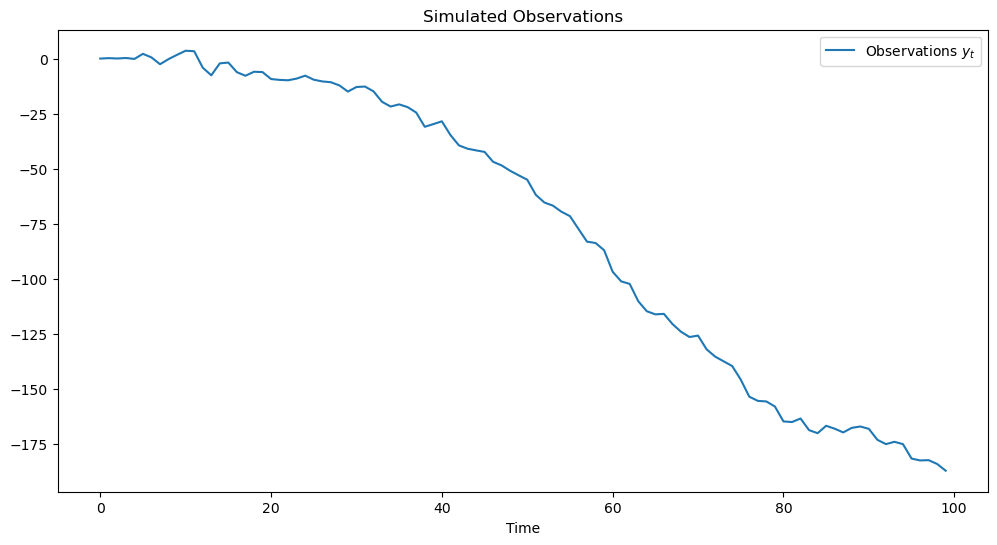

In [6]:
n_obs = 100
y_init = 0
y,alpha = simulate_data(params, n_order, n_obs, alpha_init = np.zeros(2 + 2*n_order))

#plot simulated data
plt.figure(figsize=(12, 6))
plt.plot(y, label='Observations $y_t$')
plt.legend()
plt.xlabel('Time')
plt.title('Simulated Observations')
plt.show()

## Setup for estimation

### Kalman filter and smoother

In [7]:
def kalman_filter(y, a1, P1, params, n_order):
    Z, H, T, R, Q = state_space(params, n_order)
    Z = Z.reshape(1, -1)
    n = len(y)
    state_dim = 2 + 2 * n_order

    # Initialize arrays for estimates
    a_pred = np.zeros((n, state_dim))      # Predicted state estimates (a[t|t-1])
    P_pred = np.zeros((n, state_dim, state_dim))  # Predicted state covariances (P[t|t-1])
    a_filt = np.zeros((n, state_dim))      # Filtered state estimates (a[t|t])
    P_filt = np.zeros((n, state_dim, state_dim))  # Filtered state covariances (P[t|t])
    v = np.zeros(n)                        # Prediction errors
    F = np.zeros(n)                        # Prediction error variances
    K = np.zeros((n, state_dim))           # Kalman gain

    # Initial state
    a_filt[0] = a1
    P_filt[0] = P1

    for t in range(n):
        if t == 0:
            # For t=0, predict from initial state
            a_pred[t] = T @ a_filt[0]
            P_pred[t] = T @ P_filt[0] @ T.T + R @ Q @ R.T
        else:
            # Prediction step: 
            a_pred[t] = T @ a_filt[t - 1]
            P_pred[t] = T @ P_filt[t - 1] @ T.T + R @ Q @ R.T

        # Observation prediction: 
        y_pred = Z @ a_pred[t]

        # Prediction error (innovation): 
        v[t] = y[t] - y_pred.item()

        # Prediction error variance: 
        F[t] = (Z @ P_pred[t] @ Z.T).item() + H

        # Kalman gain: 
        K_t = P_pred[t] @ Z.T / F[t]
        K[t] = K_t.flatten()

        # Update state estimate: 
        a_filt[t] = a_pred[t] + K_t.flatten() * v[t]

        # Update covariance estimate
        P_filt[t] = P_pred[t] - K_t @ Z @ P_pred[t]

    return a_pred, P_pred, a_filt, P_filt, v, F, K

In [8]:
def kalman_smoother(y, a1, P1, params, n_order):
    n = len(y)
    state_dim = 2 + 2 * n_order

    # Run Kalman filter
    a_pred, P_pred, a_filt, P_filt, v, F, K = kalman_filter(y, a1, P1, params, n_order)

    # Initialize arrays for smoothed estimates
    a_smooth = np.zeros((n, state_dim))
    P_smooth = np.zeros((n, state_dim, state_dim))

    # Get state-space matrices
    Z, H, T, R, Q = state_space(params, n_order)

    # Backward recursion
    for t in reversed(range(n)):
        if t == n - 1:
            a_smooth[t] = a_filt[t]
            P_smooth[t] = P_filt[t]
        else:
            P_pred_inv = np.linalg.inv(P_pred[t + 1])
            J = P_filt[t] @ T.T @ P_pred_inv
            a_smooth[t] = a_filt[t] + J @ (a_smooth[t + 1] - a_pred[t + 1])
            P_smooth[t] = P_filt[t] + J @ (P_smooth[t + 1] - P_pred[t + 1]) @ J.T

    return a_smooth, P_smooth


In [9]:
def log_likelihood(params, y, a1, P1, n_order):
    # run kalmann filter
    a_pred, P_pred, a_filt, P_filt, v, F, K = kalman_filter(y, a1, P1, params, n_order)
    
    loglik = -0.5 * (np.sum(np.log(2*np.pi) + np.log(abs(F)) + (v**2/F)))

    return loglik

def negative_log_likelihood(params, y, a1, P1, n_order):
    return -log_likelihood(params, y, a1, P1, n_order)

## Setup for MCMC

In [10]:

def transform_params(params_unbounded, a_rho=0.001, b_rho=0.970, a_lambda=0.001, b_lambda=np.pi):
    'Get the bounded paramters from unbounded draws'

    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2, gamma_sigma_epsilon2 = params_unbounded

    # Transform gamma_rho (Uniform transformation for rho)
    exp_gamma_rho = np.exp(gamma_rho)
    rho = (a_rho + b_rho * exp_gamma_rho) / (1 + exp_gamma_rho)

    # Transform gamma_lambda_c (Uniform transformation for lambda_c)
    exp_gamma_lambda = np.exp(gamma_lambda_c)
    lambda_c = (a_lambda + b_lambda * exp_gamma_lambda) / (1 + exp_gamma_lambda)

    # Transform variance parameters (Inverse-Gamma transformation)
    sigma_xi2 = np.exp(gamma_sigma_xi2)
    sigma_kappa2 = np.exp(gamma_sigma_kappa2)
    sigma_epsilon2 = np.exp(gamma_sigma_epsilon2)

    return rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2





def log_derivatives_params(params_unbounded, a_rho=0.001, b_rho=0.970, a_lambda=0.001, b_lambda=np.pi):
    'Get the jacobian of the parameter transformations'

    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2, gamma_sigma_epsilon2 = params_unbounded
    
    # Log derivative for rho
    log_derivative_rho = np.log(b_rho - a_rho) + gamma_rho - 2*np.log(1 + np.exp(gamma_rho))
    # Log derivative for lambda_c
    log_derivative_lambda_c = np.log(b_lambda - a_lambda) + gamma_lambda_c - 2*np.log(1 + np.exp(gamma_lambda_c))

    # Log derivatives for variance parameters
    log_derivative_sigma_xi2 = gamma_sigma_xi2
    log_derivative_sigma_kappa2 = gamma_sigma_kappa2
    log_derivative_sigma_epsilon2 = gamma_sigma_epsilon2

    return (log_derivative_rho, log_derivative_lambda_c, 
            log_derivative_sigma_xi2, log_derivative_sigma_kappa2, log_derivative_sigma_epsilon2)


In [11]:

# Define log prior
def log_prior(theta):
    rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2 = theta

    # log prior rho (uniform 0 to 0.999)
    a = 0
    b = 0.999
    log_prior_rho = np.log(1/(b-a))

    # log prior lambda_c (uniform 0 to pi)
    a = 0
    b = np.pi
    log_prior_lambda_c = np.log(1/(b-a))


    # Inverse-Gamma priors for variance parameters
    a = 3
    b = 1
    log_prior_sigma_xi2 = a * np.log(b) - gammaln(a) - (a + 1) * np.log(sigma_xi2) - b / sigma_xi2
    log_prior_sigma_kappa2 = a * np.log(b) - gammaln(a) - (a + 1) * np.log(sigma_kappa2) - b / sigma_kappa2
    log_prior_sigma_epsilon2 = a * np.log(b) - gammaln(a) - (a + 1) * np.log(sigma_epsilon2) - b / sigma_epsilon2

    return log_prior_lambda_c + log_prior_rho + log_prior_sigma_xi2 + log_prior_sigma_kappa2 + log_prior_sigma_epsilon2



# Define log posterior
def log_posterior(gamma, y, a1, P1, n_order):
    theta = transform_params(gamma)
    rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2 = theta

    log_lik = log_likelihood(theta, y, a1, P1, n_order)
    log_pri = log_prior(theta)

    if log_pri == -np.inf or np.isnan(log_lik):
        return -np.inf

    log_jacobian = np.sum(log_derivatives_params(gamma))

    return log_lik + log_pri + log_jacobian


# MCMC

### Initialization

In [12]:

def initialize_mcmc(y, a1, P1, n_order, 
                   n_init=40000, 
                   burn_init=5000, 
                   omega_init=0.1):

    dim = 5  # Number of parameters: rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2

    # Initialize storage for the chain
    chain_init = np.zeros((n_init, dim))
    current_gamma = np.zeros(dim)  # Initial value for gamma
    current_log_post = log_posterior(current_gamma, y, a1, P1, n_order)

    accept_init = 0

    for s in tqdm(range(n_init), desc="Initialization Phase"):
        # Propose Gamma*
        gamma_star = np.random.multivariate_normal(current_gamma, omega_init * np.eye(dim))
        
        # Compute log posterior
        log_post_star = log_posterior(gamma_star, y, a1, P1, n_order)
        
        # Acceptance probability
        if log_post_star == -np.inf:
            eta = 0
        else:
            eta = min(1, np.exp(log_post_star - current_log_post))
        
        # Accept or reject
        if np.random.uniform(0,1) < eta:
            chain_init[s] = gamma_star
            current_gamma = gamma_star
            current_log_post = log_post_star
            accept_init +=1
        else:
            chain_init[s] = current_gamma

    acceptance_rate_init = accept_init / n_init
    print(f"Initialization Acceptance Rate: {acceptance_rate_init*100:.2f}%")

    # Discard burn-in
    chain_init_burned = chain_init[burn_init:]

    # Compute covariance matrix from initialization
    Sigma = np.cov(chain_init_burned, rowvar=False)

    return chain_init_burned, Sigma, acceptance_rate_init

### Recursion

In [13]:



def recursion_mcmc(y, a1, P1, n_order, 
                  chain_init_burned, Sigma, 
                  n_rec=20000, 
                  burn_rec=10000, 
                  omega_rec=0.1):
  
    dim = 5  # Number of parameters: rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2

    # Initialize storage for the recursion chain
    chain_rec = np.zeros((n_rec, dim))
    theta_samples = np.zeros((n_rec, dim))

    # Start from the last point of the initialization chain
    current_gamma_rec = chain_init_burned[-1].copy()
    current_log_post_rec = log_posterior(current_gamma_rec, y, a1, P1, n_order)
    
    accept_rec = 0

    # Placeholder for alphas
    state_dim = 2 + 2 * n_order
    alphas = []

    for q in tqdm(range(n_rec), desc="Recursion Phase"):
        # Propose Gamma*
        gamma_star = np.random.multivariate_normal(current_gamma_rec, omega_rec * Sigma)
        # gamma_star = np.random.multivariate_normal(current_gamma_rec, omega_rec * np.eye(dim))
        
        # Compute log posterior
        log_post_star = log_posterior(gamma_star, y, a1, P1, n_order)
        
        # Acceptance probability
        if log_post_star == -np.inf:
            eta = 0
        else:
            eta = min(1, np.exp(log_post_star - current_log_post_rec))
        
        # Accept or reject
        if np.random.uniform(0,1) < eta:
            chain_rec[q] = gamma_star
            current_gamma_rec = gamma_star
            current_log_post_rec = log_post_star
            accept_rec +=1
        else:
            chain_rec[q] = current_gamma_rec
        
        theta_samples[q] = transform_params(current_gamma_rec)

        # After burn-in, perform Gibbs sampling for states
        if q >= (burn_rec):
            theta = transform_params(current_gamma_rec)
            rho, lambda_c, sigma_xi2, sigma_kappa2, sigma_epsilon2 = theta

            # Sample states using Gibbs sampling
            # Step 1: Draw alpha^+
            alpha_plus_draw = np.random.multivariate_normal(np.zeros(state_dim), P1)
            
            # Step 2: Simulate forward recursion to get y^+
            y_plus,alpha_plus = simulate_data(theta, n_order, len(y), alpha_plus_draw)
            
            # Step 3: Construct y*
            y_star = y - y_plus
            
            # Step 4: Compute E(alpha | y*)
            alpha_hat, _ = kalman_smoother(y_star, a1, P1, theta, n_order)
             
            # Step 5: Draw alpha^*
            alpha_star = alpha_hat + alpha_plus  # Adjusted state
            
            # Store the sampled alpha
            alphas.append(alpha_star)

    acceptance_rate_rec = accept_rec / n_rec
    print(f"Recursion Acceptance Rate: {acceptance_rate_rec*100:.2f}%")

    # Discard burn-in
    chain_rec_burned = chain_rec[burn_rec:]
    theta_samples_burned = theta_samples[burn_rec:]


    # Since Gibbs sampling starts after n_rec - burn_rec, we collect only the last burn_rec samples
    alpha_samples = np.array(alphas)

    return theta_samples, alpha_samples, acceptance_rate_rec



## Results

### MCMC

In [14]:

n_obs = len(y)

# Initial state and covariance estimates
state_dim = 2 + 2 * n_order
a1 = np.zeros(state_dim)
P1 = np.eye(state_dim) * 100

# Perform Initialization Phase
chain_init_burned, Sigma, acceptance_rate_init = initialize_mcmc(
    y, a1, P1, n_order,
    n_init=40000,
    burn_init=5000,
    omega_init=0.01
)

# Perform Recursion Phase
chain_rec_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, a1, P1, n_order,
    chain_init_burned, Sigma,
    n_rec=20000,
    burn_rec=10000,
    omega_rec=0.5
)



Initialization Phase: 100%|██████████| 40000/40000 [01:02<00:00, 638.63it/s]


Initialization Acceptance Rate: 52.98%


Recursion Phase: 100%|██████████| 20000/20000 [01:30<00:00, 220.24it/s]


Recursion Acceptance Rate: 46.28%


### MLE

In [15]:
# Initial guesses for parameters
initial_params = [0.5, 0.2, 0.5, 0.5, 0.5]

# Bounds for parameters to ensure valid values
bounds = [
    (0.0, 0.999),     # rho: 
    (0.0, np.pi),        # lambda_c: Frequency between 0 and pi
    (1e-6, None),        # sigma_xi2: Variance, positive
    (1e-6, None),        # sigma_kappa2: Variance, positive
    (1e-6, None),        # sigma_epsilon2: Variance, positive
]

# Initial state and covariance estimates
state_dim = 2 + 2 * n_order
a1 = np.zeros(state_dim)
P1 = np.eye(state_dim) * 100

# Perform optimization to estimate parameters
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(y, a1, P1, n_order),
    method='SLSQP',
    bounds=bounds,
    options={'disp': True}
)

# Extract the estimated parameters
estimated_params = result.x

c:\Users\wrc938\AppData\Local\Anaconda\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 228.47318946020533
            Iterations: 33
            Function evaluations: 223
            Gradient evaluations: 32


### Results

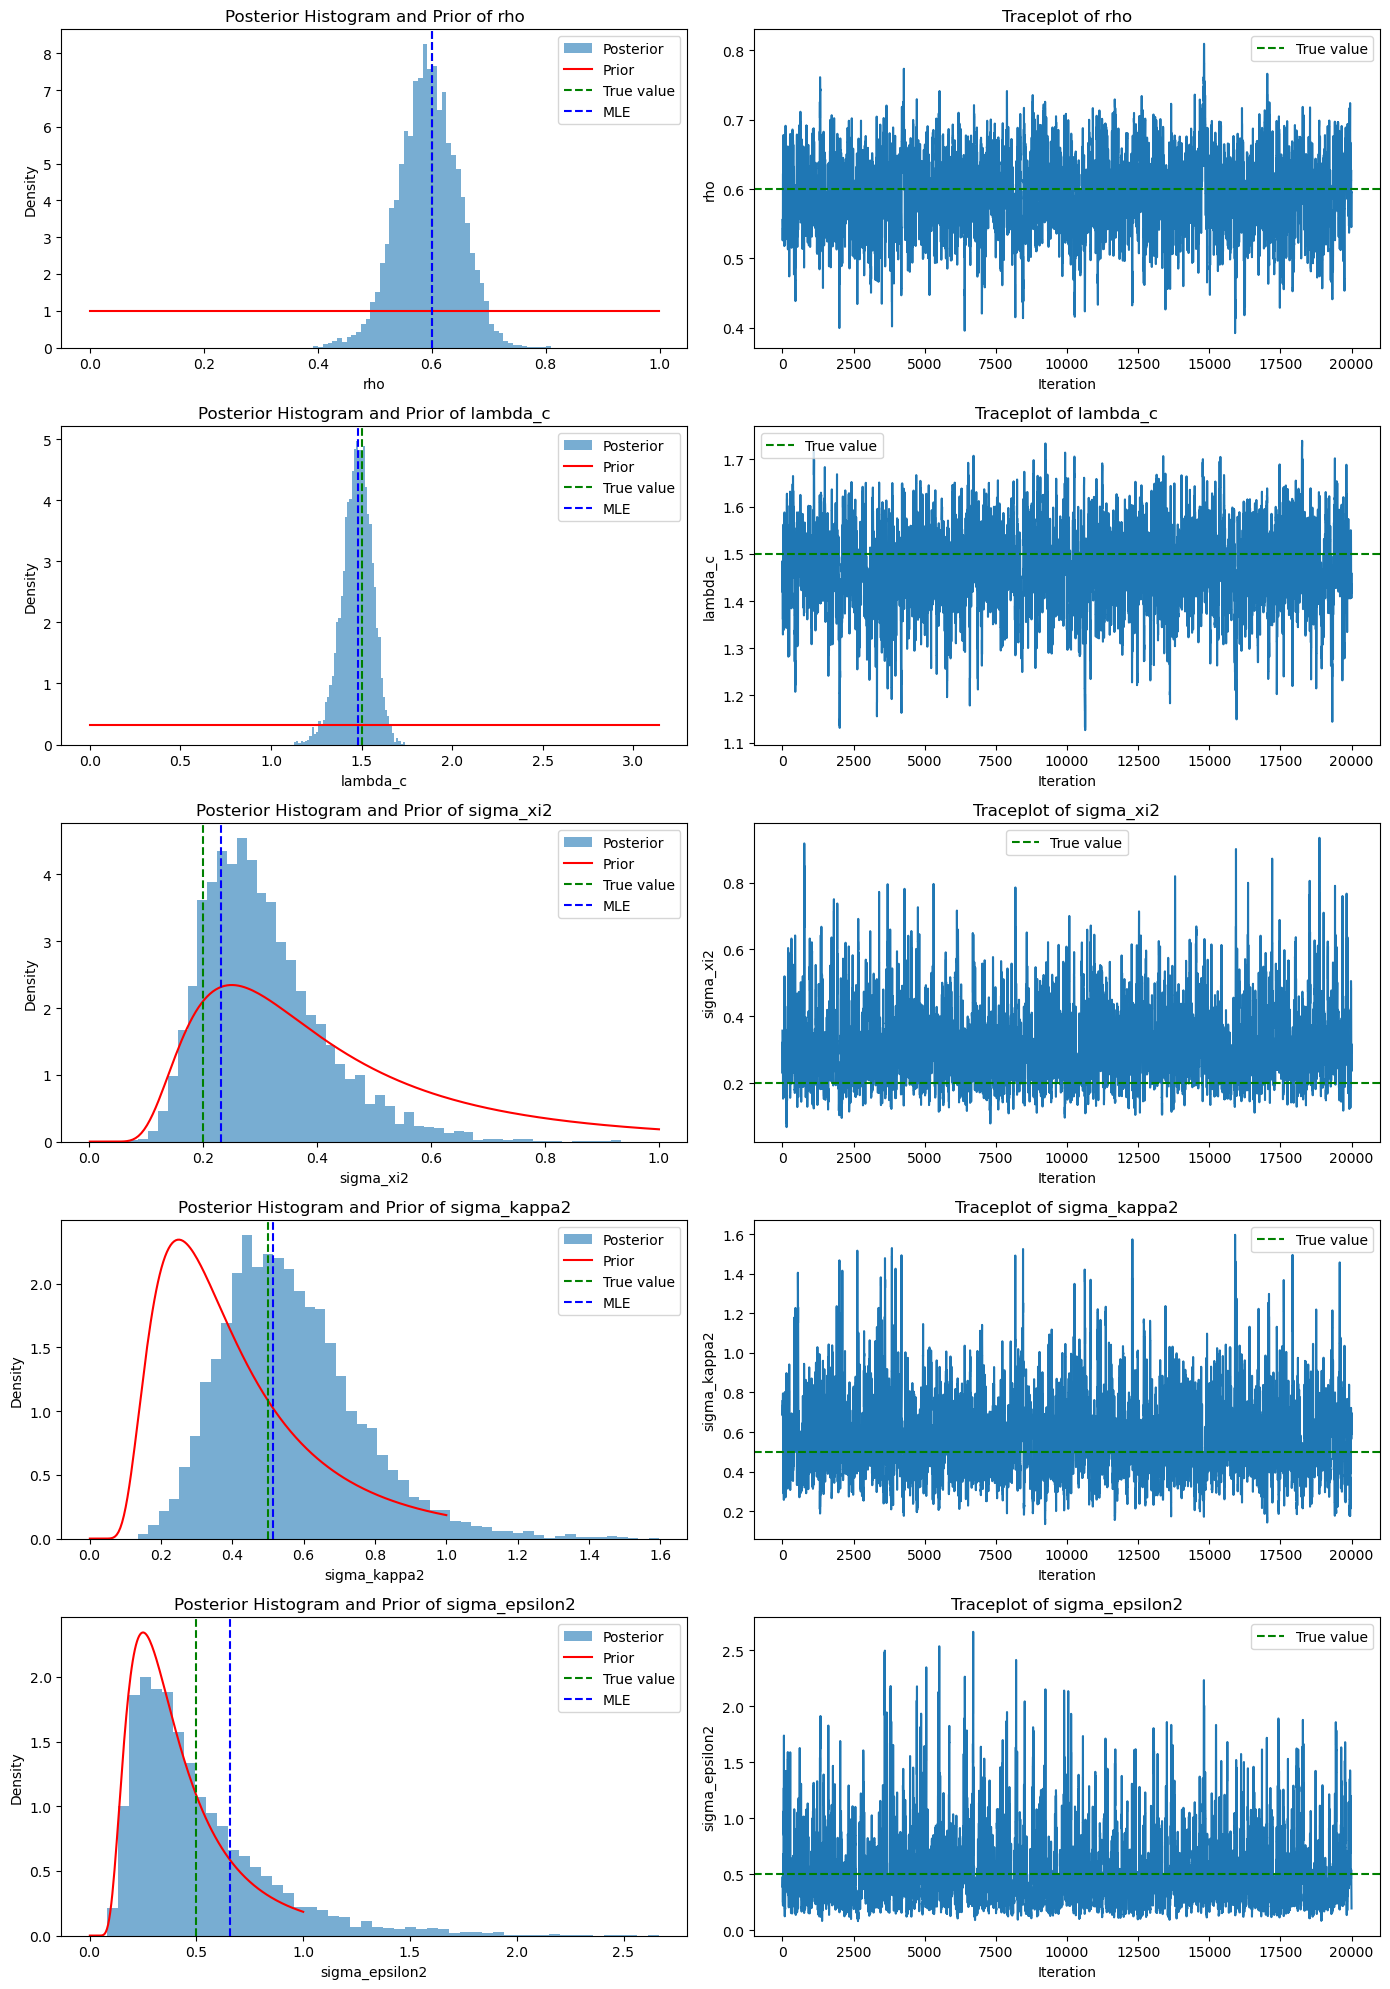

,Parameter,MCMC Estimate,MLE Estimate,True Value
0,rho,0.594315,0.600555,0.6
1,lambda_c,1.472775,1.477436,1.5
2,sigma_xi2,0.306369,0.231009,0.2
3,sigma_kappa2,0.564982,0.513354,0.5
4,sigma_epsilon2,0.506956,0.658704,0.5


In [16]:

parameters= ['rho', 'lambda_c', 'sigma_xi2', 'sigma_kappa2', 'sigma_epsilon2']

true_params = params
n_params = len(params)

fig, axs = plt.subplots(n_params, 2, figsize=(14, 20))

for i in range(n_params):
    param_samples = chain_rec_burned[:, i]
    
    # Plot histogram
    ax = axs[i, 0]
    ax.hist(param_samples, bins=50, density=True, alpha=0.6, label='Posterior')
    
    # Plot prior
    if parameters[i] == 'rho':
        # Uniform prior between 0 and 0.999
        a = 0
        b = 0.999
        x_values = np.linspace(a, b, 200)
        prior_pdf = uniform.pdf(x_values, loc=a, scale=b - a)
    elif parameters[i] == 'lambda_c':
        # Uniform prior between 0 and pi
        a = 0
        b = np.pi
        x_values = np.linspace(a, b, 200)
        prior_pdf = uniform.pdf(x_values, loc=a, scale=b - a)
    else:
        # Inverse-Gamma prior with a=3, b=1
        a_ig = 3
        b_ig = 1
        x_min = 0.001  # Avoid zero for invgamma
        x_max = max(1,estimated_params[i]) 
        x_values = np.linspace(x_min, x_max, 200)
        prior_pdf = invgamma.pdf(x_values, a=a_ig, scale=b_ig)
    
    # Plot prior
    ax.plot(x_values, prior_pdf, label='Prior', color='red')
    # Include true parameter value
    ax.axvline(x=true_params[i], color='green', linestyle='--', label='True value')
    # Include MLE estime
    ax.axvline(x=estimated_params[i], color='blue', linestyle='--', label='MLE')
    ax.set_xlabel(parameters[i])
    ax.set_ylabel('Density')
    ax.set_title(f"Posterior Histogram and Prior of {parameters[i]}")
    ax.legend()
    
    # Plot traceplot
    ax = axs[i, 1]
    ax.plot(param_samples)
    ax.set_xlabel('Iteration')
    ax.set_ylabel(parameters[i])
    ax.set_title(f"Traceplot of {parameters[i]}")
    ax.axhline(y=true_params[i], color='green', linestyle='--', label='True value')
    ax.legend()

plt.tight_layout()
plt.show()


#make table of estimates
chain_rec_burned_means = chain_rec_burned.mean(axis=0)
data = {
    "Parameter": parameters,
    "MCMC Estimate": chain_rec_burned_means,
    "MLE Estimate": estimated_params,
    "True Value": true_params
}
param_df = pd.DataFrame(data)
display(param_df)



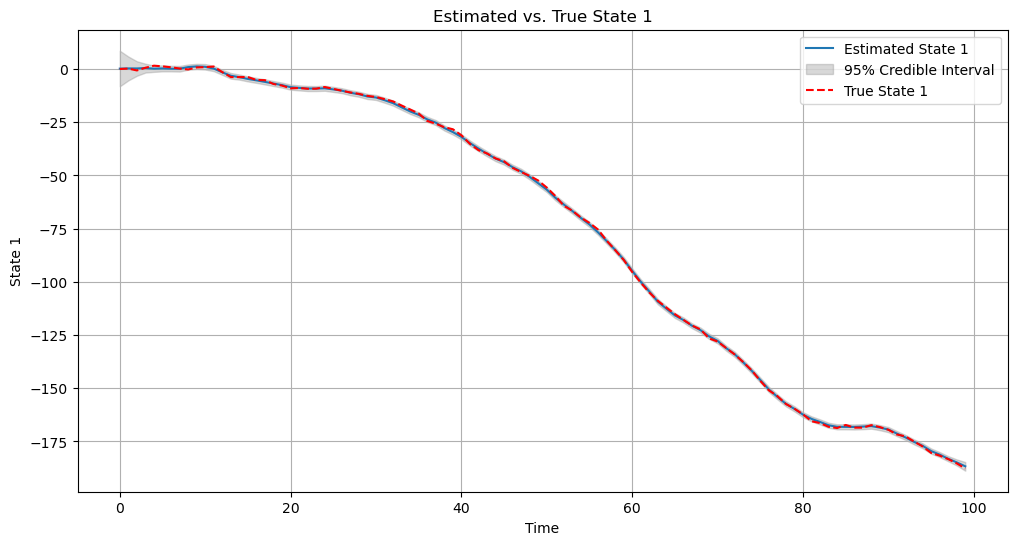

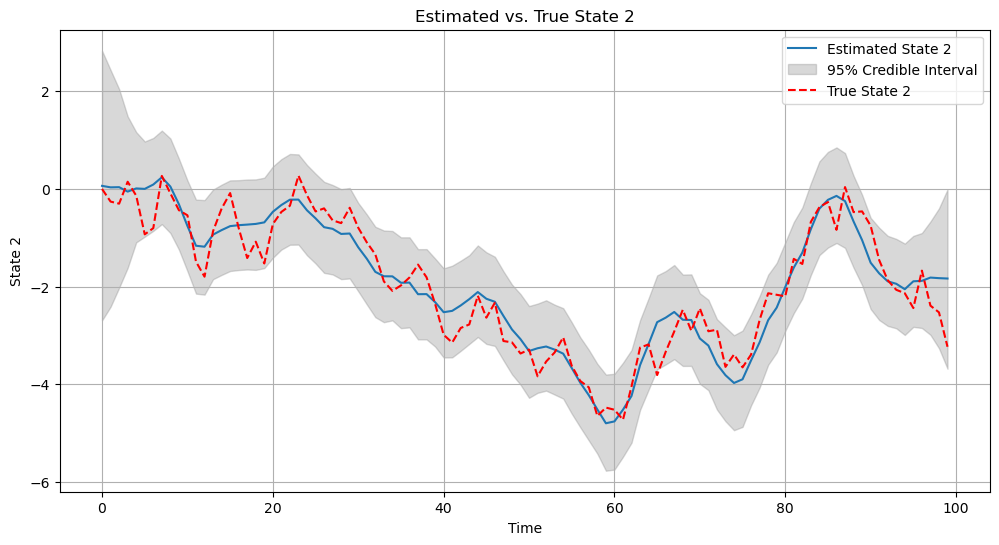

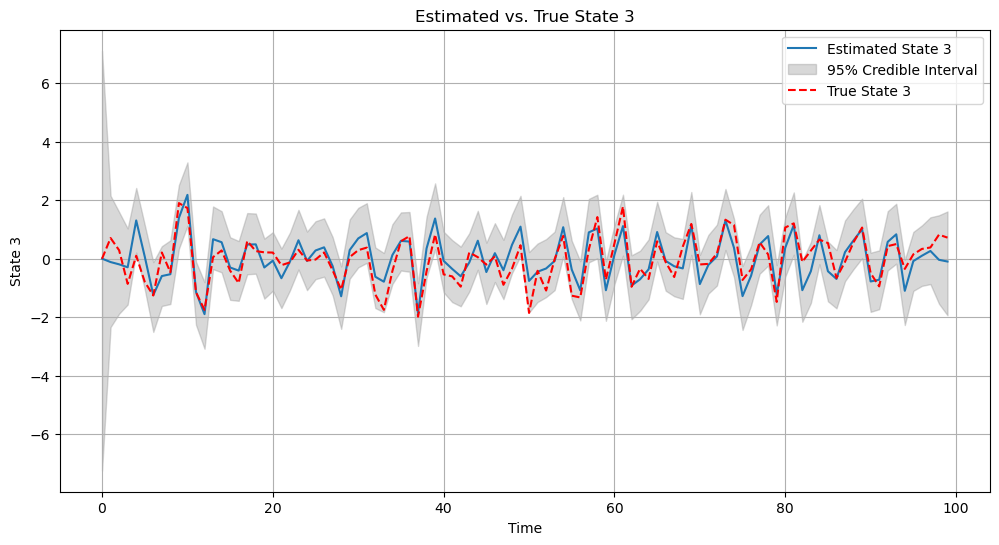

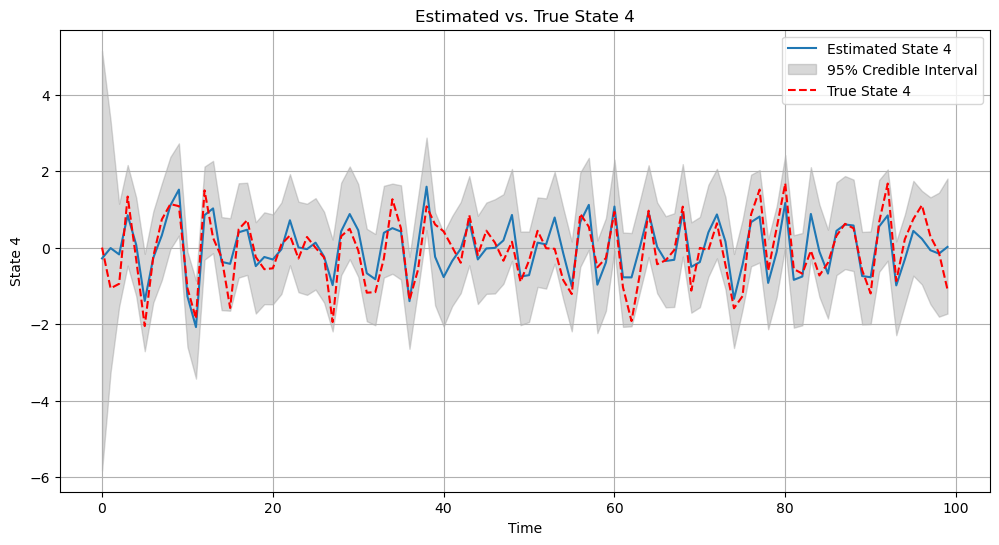

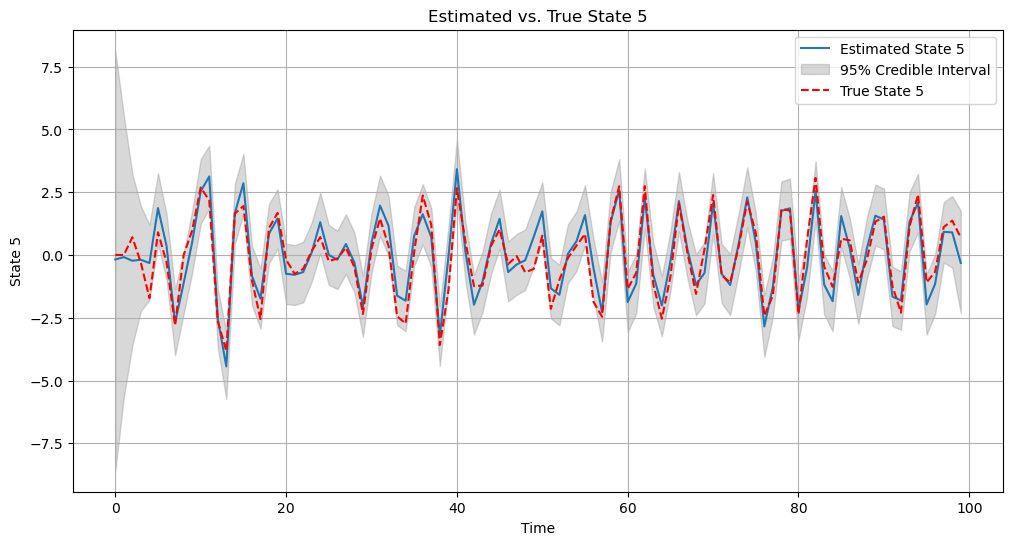

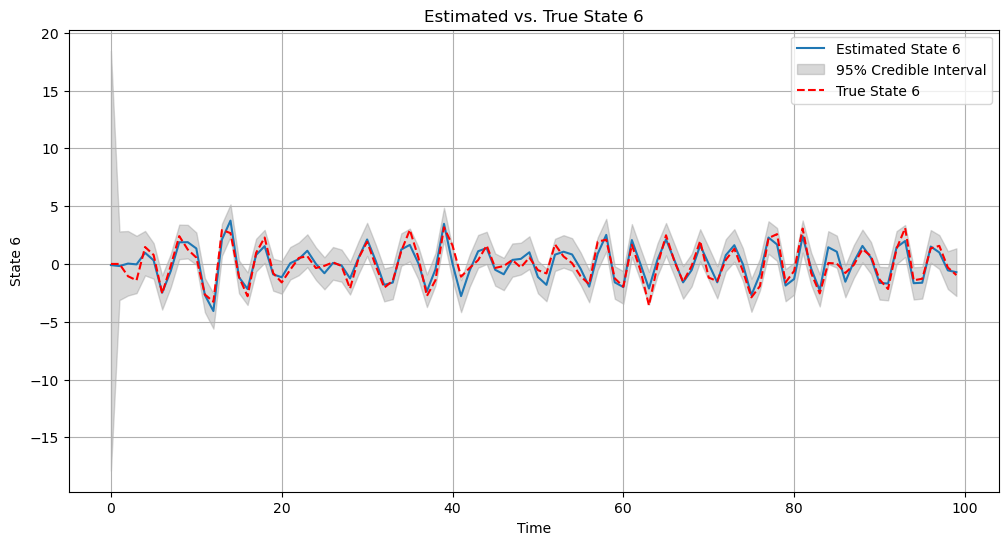

In [17]:
alpha_samples_cut = alpha_samples[:,:]  
n_samples, n_time_steps, state_dim = alpha_samples_cut.shape


# Compute posterior mean and credible intervals
alpha_mean = np.mean(alpha_samples_cut, axis=0)  # Shape: (n_time_steps, state_dim)
alpha_lower = np.percentile(alpha_samples_cut, 2.5, axis=0)
alpha_upper = np.percentile(alpha_samples_cut, 97.5, axis=0)

time = np.arange(n_time_steps)

# Plot each state dimension
for s in range(state_dim):
    plt.figure(figsize=(12, 6))
    plt.plot(time, alpha_mean[:, s], label=f'Estimated State {s+1}')
    plt.fill_between(time, alpha_lower[:, s], alpha_upper[:, s], color='gray', alpha=0.3, label='95% Credible Interval')
    # Plot true state
    plt.plot(time, alpha[:, s], label=f'True State {s+1}', linestyle='--', color='red')
    plt.xlabel('Time')
    plt.ylabel(f'State {s+1}')
    plt.title(f'Estimated vs. True State {s+1}')
    plt.legend()
    plt.grid()
    plt.show()


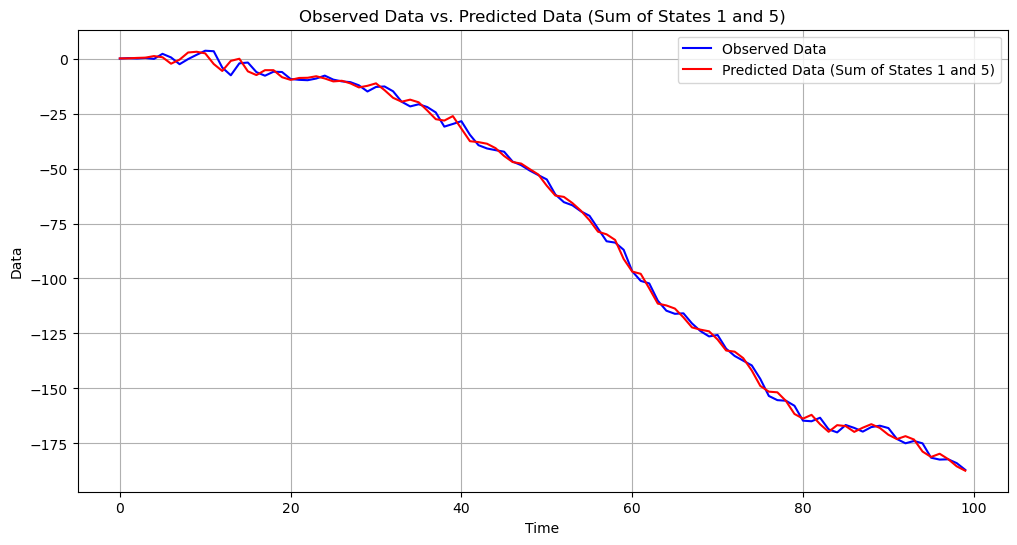

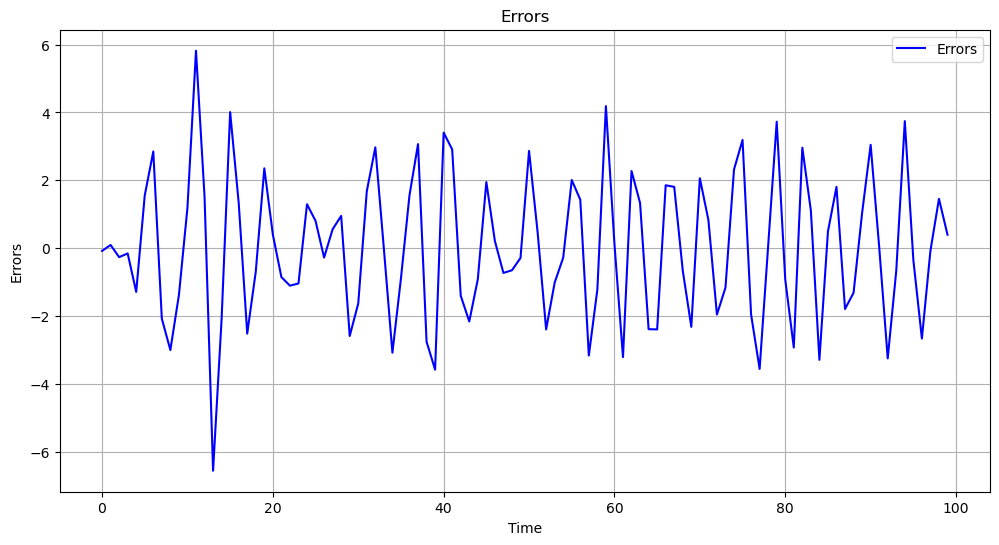

In [18]:

# Compute the posterior mean of the states
alpha_mean = np.mean(alpha_samples, axis=0)  # Shape: (n_time_steps, state_dim)

# Sum of the relevant states (State 1 and State 5 in MATLAB terms, which are indices 0 and 4 in Python)
y_pred = alpha_mean[:, 0] + alpha_mean[:, (2+2*n_order)-1]

# Plot the observed data and the predicted data
time = np.arange(len(y))

plt.figure(figsize=(12, 6))
plt.plot(time, y, label='Observed Data', color='blue')
plt.plot(time, y_pred, label='Predicted Data (Sum of States 1 and 5)', color='red')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('Observed Data vs. Predicted Data (Sum of States 1 and 5)')
plt.legend()
plt.grid(True)
plt.show()

#plot errors
errors = y - y_pred
plt.figure(figsize=(12, 6))
plt.plot(time, errors, label='Errors', color='blue')
plt.xlabel('Time')
plt.ylabel('Errors')
plt.title('Errors')
plt.legend()
plt.grid(True)
plt.show()